In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.distributions import constraints
import functools

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, JitTraceEnum_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList, AutoDelta
from pyro.optim import ClippedAdam

# Download required resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


/opt/homebrew/Caskroom/miniconda/base/envs/bml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jensparslov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jensparslov/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jensparslov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from data import add_mask_column
import torch
import numpy as np
df = pd.read_csv("tmdb_5000_movies.csv")
df.dropna(subset=['overview'], inplace=True)

vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=1000, stop_words="english"
)
 
def VectorizeText(text, vectorizer):
    X_count = vectorizer.fit_transform(df['overview'])
    list_of_word_indices_per_doc = []
    if hasattr(X_count, 'indptr'): # Check if it's likely CSR or similar

        for i in range(X_count.shape[0]): # Iterate through each document/row
            word_indices_for_doc_i = X_count[i].indices
            list_of_word_indices_per_doc.append(word_indices_for_doc_i.tolist())

    else:
        for i in range(X_count.shape[0]):
            row = X_count[i].toarray().flatten() # Convert sparse row to dense array
            word_indices_for_doc_i = np.nonzero(row)[0] # Get indices of non-zero elements
            list_of_word_indices_per_doc.append(word_indices_for_doc_i.tolist())
    

    #for i, indices in enumerate(list_of_word_indices_per_doc):
    #    print(f"Document {i}: {indices}")

    # Get the words corresponding to the indices

    return list_of_word_indices_per_doc

# Example usage
list_of_word_indices_per_doc = VectorizeText(df['overview'], vectorizer)
doc = list_of_word_indices_per_doc[1]
# convert to words
df["indexed_overview"] = list_of_word_indices_per_doc
sequence_length = 60
num_words_per_doc = sequence_length

df = add_mask_column(df, 'indexed_overview', 
                         length=sequence_length, 
                         new_column_name="indexed_overview_masked",)

W = df["indexed_overview"]
Mask = df["indexed_overview_masked"]
#rating = df["vote_average"]
#rating = rating.round().astype(int)
#rating = torch.tensor(rating.values, dtype=torch.long)

# Convert to a LongTensor (2D tensor)
tensor_W = torch.tensor(W.tolist(), dtype=torch.long).T
tensor_Mask = torch.tensor(Mask.tolist(), dtype=torch.bool).T


In [ ]:
#from data import load_data_with_sklearn
#tensor_W, tensor_Mask, pyro_idx_to_word_map, num_vocab_words, df, pyro_word_to_idx_map = load_data_with_sklearn()

In [17]:
num_topics = 10
num_words = len(vectorizer.get_feature_names_out())
num_docs = tensor_W.shape[1]

In [18]:
def model(data=None, mask=None, batch_size=None, ratings=None, num_classes=None, device="cpu"):
    """LDA model with masking for variable-length documents."""
    with pyro.plate("topics", num_topics):
        topic_words = pyro.sample(
            "topic_words", dist.Dirichlet(torch.ones(num_words) / num_topics)
        )
    
    # Ordinal regression parameters (priors)
    regression_coefs = None
    cutpoints = None

    if ratings is not None:
        if num_classes is None:
            raise ValueError("num_classes must be specified if ratings are provided.")
        if num_classes <= 1:
            raise ValueError("num_classes must be greater than 1 for ordinal regression.")

        # Priors for regression coefficients (one per topic)
        regression_coefs = pyro.sample(
            "regression_coefs",
            dist.Normal(torch.zeros(num_topics, device=device),
                        torch.ones(num_topics, device=device)).to_event(1)
        )

        # Priors for cutpoints (num_classes - 1 cutpoints, ordered)
        # c_0 ~ Normal
        # c_i = c_{i-1} + exp(delta_i), where delta_i ~ Normal for i > 0
        # This creates c_0 < c_1 < ... < c_{K-2}
        
        # Sample the first cutpoint
        c_0 = pyro.sample("c_0", 
                          dist.Normal(torch.tensor(0., device=device), 
                                      torch.tensor(5., device=device))) 
        
        if num_classes > 2: # If more than one cutpoint is needed (i.e., num_classes - 1 > 1)
            # Sample log differences for the remaining num_classes - 2 cutpoints
            # These correspond to log(c_1 - c_0), log(c_2 - c_1), ...
            log_diffs = pyro.sample(
                "log_diffs",
                dist.Normal(torch.zeros(num_classes - 2, device=device),
                            torch.ones(num_classes - 2, device=device)).to_event(1)
            )
            # Calculate cutpoints: c_0, c_0 + exp(log_diffs_0), c_0 + exp(log_diffs_0) + exp(log_diffs_1), ...
            # These are then c_0, c_1, c_2, ...
            incremental_cutpoints = c_0 + torch.cumsum(torch.exp(log_diffs), dim=-1)
            cutpoints = torch.cat([c_0.unsqueeze(0), incremental_cutpoints])
        elif num_classes == 2: # Exactly one cutpoint: c_0
            cutpoints = c_0.unsqueeze(0)
        # If num_classes == 1, an error was raised earlier. No cutpoints needed.


    with pyro.plate("documents", num_docs, batch_size) as ind:
        data = data[:, ind]  # data: [max_words, batch_size]
        if mask is not None:
            mask = mask[:, ind]  # same shape as data

        ratings_batch = None
        if ratings is not None: # ratings should be (num_docs,)
            ratings_batch = ratings[ind]
        
        doc_topics = pyro.sample(
            "doc_topics", dist.Dirichlet(torch.ones(num_topics) / num_topics)
        )
        
        # Ordinal regression part
        if ratings is not None and regression_coefs is not None and cutpoints is not None:
            # regression_coefs shape: (num_topics)
            # doc_topics shape: (batch_size, num_topics)
            # eta = (doc_topics * regression_coefs.unsqueeze(0)).sum(dim=-1)
            # Using matmul for clarity:
            eta = torch.matmul(doc_topics, regression_coefs) # (batch_size, num_topics) @ (num_topics) -> (batch_size)
            
            pyro.sample(
                "observed_ratings",
                dist.OrderedLogistic(predictor=eta, cutpoints=cutpoints, validate_args=True),
                obs=ratings_batch # ratings_batch should be (batch_size,) and contain integer classes 0..K-1
            )

        with pyro.plate("words", num_words_per_doc):
            with pyro.poutine.mask(mask=mask):
                word_topics = pyro.sample(
                    "word_topics", dist.Categorical(doc_topics),
                    infer={"enumerate": "parallel"}
                )

                doc_words = pyro.sample(
                    "doc_words",
                    dist.Categorical(topic_words[word_topics]),
                    obs=data
                )


    if ratings is not None:
        return topic_words, doc_words, regression_coefs, cutpoints
    else:
        return topic_words, doc_words

In [19]:
pyro.clear_param_store()

def my_local_guide(data=None, mask=None, batch_size=None, ratings=None, num_classes=None, device="cpu"): # Added ratings, num_classes, device
    # Guide for topic_words
    topic_words_posterior = pyro.param(
            "topic_words_posterior", # Kept original name
            lambda: torch.ones(num_topics, num_words, device=device), # Added device
            constraint=constraints.positive)

    with pyro.plate("topics", num_topics):
        pyro.sample("topic_words", dist.Dirichlet(topic_words_posterior))

    # Guide for ordinal regression parameters (if model includes them)
    if ratings is not None:
        if num_classes is None:
            raise ValueError("num_classes must be specified for guide if ratings are provided.")
        if num_classes <= 1:
            raise ValueError("num_classes must be greater than 1 for ordinal regression in guide.")

        # Guide for regression_coefs
        q_regr_coefs_loc = pyro.param(
            "q_regr_coefs_loc",
            lambda: torch.zeros(num_topics, device=device))
        q_regr_coefs_scale = pyro.param(
            "q_regr_coefs_scale",
            lambda: torch.ones(num_topics, device=device),
            constraint=constraints.positive)
        pyro.sample("regression_coefs",
                    dist.Normal(q_regr_coefs_loc, q_regr_coefs_scale).to_event(1))

        # Guide for c_0
        q_c0_loc = pyro.param(
            "q_c0_loc",
            lambda: torch.tensor(0.0, device=device))
        q_c0_scale = pyro.param(
            "q_c0_scale",
            lambda: torch.tensor(1.0, device=device),
            constraint=constraints.positive)
        pyro.sample("c_0", dist.Normal(q_c0_loc, q_c0_scale))

        if num_classes > 2:
            # Guide for log_diffs
            q_log_diffs_loc = pyro.param(
                "q_log_diffs_loc",
                lambda: torch.zeros(num_classes - 2, device=device))
            q_log_diffs_scale = pyro.param(
                "q_log_diffs_scale",
                lambda: torch.ones(num_classes - 2, device=device),
                constraint=constraints.positive)
            pyro.sample("log_diffs",
                        dist.Normal(q_log_diffs_loc, q_log_diffs_scale).to_event(1))

    # Guide for doc_topics
    doc_topics_posterior = pyro.param(
            "doc_topics_posterior", # Kept original name
            lambda: torch.ones(num_docs, num_topics, device=device), # Added device
            constraint=constraints.positive) # Changed to positive for Dirichlet concentration

    with pyro.plate("documents", num_docs, batch_size) as ind:
        # Sample from a Dirichlet distribution for doc_topics
        pyro.sample("doc_topics", dist.Dirichlet(doc_topics_posterior[ind]))




In [20]:
# if rating.min() > 0:
#     print("Warning: Ratings are not 0-indexed. Consider adjusting them or num_classes calculation.")
# num_classes_val = rating.max().item() + 1 if rating.numel() > 0 else 0

guide = AutoGuideList(model)
guide.add(AutoDiagonalNormal(pyro.poutine.block(model, expose=['doc_topics']))) # We add the weights variables here
guide.add(my_local_guide)  # automatically wrapped in an AutoCallable

guide = my_local_guide

elbo = TraceEnum_ELBO(max_plate_nesting=3)
torch.autograd.set_detect_anomaly(True) 
optim = ClippedAdam({'lr': 0.005})
svi = SVI(model, guide, optim, elbo)

# Define the number of optimization steps
n_steps = 10000
device = "cpu"

In [21]:
running_eblo = 0.0
# do gradient steps
for step in range(n_steps):
    running_eblo += svi.step(tensor_W, tensor_Mask, ratings=None, num_classes=None, device=device, batch_size=16)
    if step % 100 == 0:
        #print('.', end='')
        print("[%d] ELBO: %.1f" % (step, running_eblo/100))
        running_eblo = 0.0

[0] ELBO: 582.0
[100] ELBO: 56293.8
[200] ELBO: 52873.3
[300] ELBO: 50015.5
[400] ELBO: 47509.1
[500] ELBO: 45980.6
[600] ELBO: 45472.5
[700] ELBO: 43717.8
[800] ELBO: 43402.5
[900] ELBO: 42529.4
[1000] ELBO: 42432.0
[1100] ELBO: 40937.4
[1200] ELBO: 40921.8
[1300] ELBO: 40480.5
[1400] ELBO: 39779.4
[1500] ELBO: 38729.6
[1600] ELBO: 38430.6
[1700] ELBO: 37956.2
[1800] ELBO: 36789.8
[1900] ELBO: 36158.1
[2000] ELBO: 35334.1
[2100] ELBO: 35008.2
[2200] ELBO: 34819.4
[2300] ELBO: 33697.9
[2400] ELBO: 32695.0
[2500] ELBO: 31839.3
[2600] ELBO: 31376.0
[2700] ELBO: 30917.9
[2800] ELBO: 30186.7
[2900] ELBO: 29513.7
[3000] ELBO: 28022.8
[3100] ELBO: 27757.3
[3200] ELBO: 27469.5
[3300] ELBO: 26370.0
[3400] ELBO: 25838.1
[3500] ELBO: 25375.4
[3600] ELBO: 24633.7
[3700] ELBO: 23889.5
[3800] ELBO: 23324.0
[3900] ELBO: 22404.1
[4000] ELBO: 22626.2
[4100] ELBO: 21419.3
[4200] ELBO: 20618.6
[4300] ELBO: 20538.4
[4400] ELBO: 19811.4
[4500] ELBO: 19033.2
[4600] ELBO: 18724.1
[4700] ELBO: 17884.4
[4800]

/opt/homebrew/Caskroom/miniconda/base/envs/bml/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: Error detected in _DirichletBackward. Traceback of forward call that caused the error:
  File "/opt/homebrew/Caskroom/miniconda/base/envs/bml/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/homebrew/Caskroom/miniconda/base/envs/bml/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/bml/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/bml/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/bml/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/opt/homebrew/Caskr

RuntimeError: Function '_DirichletBackward' returned nan values in its 0th output.

In [11]:
from data import load_data_with_sklearn
tensor_W, tensor_Mask, pyro_idx_to_word_map, num_vocab_words, df, pyro_word_to_idx_map = load_data_with_sklearn()

num_words = tensor_W.max() + 1
num_topics = 10
num_docs = tensor_W.shape[0]
num_words_per_doc = 60

In [2]:
pyro_word_to_idx_map

{'000': 0,
 '10': 1,
 '11': 2,
 '12': 3,
 '20': 4,
 'abandoned': 5,
 'ability': 6,
 'able': 7,
 'academy': 8,
 'accident': 9,
 'accidentally': 10,
 'act': 11,
 'action': 12,
 'actor': 13,
 'actually': 14,
 'adaptation': 15,
 'adventure': 16,
 'adventures': 17,
 'affair': 18,
 'africa': 19,
 'african': 20,
 'age': 21,
 'agent': 22,
 'agents': 23,
 'aging': 24,
 'ago': 25,
 'agrees': 26,
 'air': 27,
 'alex': 28,
 'alice': 29,
 'alien': 30,
 'alive': 31,
 'ambitious': 32,
 'america': 33,
 'american': 34,
 'ancient': 35,
 'andy': 36,
 'angeles': 37,
 'animal': 38,
 'animals': 39,
 'anna': 40,
 'annie': 41,
 'apart': 42,
 'apartment': 43,
 'appears': 44,
 'armed': 45,
 'army': 46,
 'arrives': 47,
 'art': 48,
 'artist': 49,
 'arts': 50,
 'aspiring': 51,
 'assassin': 52,
 'assigned': 53,
 'assignment': 54,
 'assistant': 55,
 'attack': 56,
 'attempt': 57,
 'attempts': 58,
 'author': 59,
 'away': 60,
 'baby': 61,
 'bad': 62,
 'band': 63,
 'bank': 64,
 'bar': 65,
 'based': 66,
 'basketball': 67,

In [ ]:
# pyro.get_param_store()._parameters = torch.load(
#     "model_params.pyro", map_location='cpu', weights_only=False
# )
# print("Model loaded with weights_only=False (use with caution).")

Model loaded with weights_only=False (use with caution).


In [13]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=100,
                        return_sites=("topic_words",))
samples = predictive(tensor_W,
                     tensor_Mask,
                     batch_size=4, 
                     #ratings=None,
                     #num_classes=num_classes_val,
                     device=device)

topics = samples["topic_words"]
topics = topics[:, 0].mean(axis=0)

RuntimeError: shape '[100, 1, 10, 1]' is invalid for input of size 1000000

In [32]:
for i in range(num_topics):
    topic = topics[i]
    top_10 = topic.argsort(descending=True)[:10]
    top_words = [pyro_idx_to_word_map[int(idx)] for idx in top_10]
    print(f"Top 10 words for Topic {i}:")
    for i in range(10):
        print(f"{i+1}: {top_words[i]}")


Top 10 words for Topic 0:
1: time
2: life
3: world
4: new
5: young
6: dark
7: danger
8: year
9: return
10: peter
Top 10 words for Topic 1:
1: world
2: captain
3: peter
4: past
5: evil
6: jack
7: quest
8: ship
9: friend
10: man
Top 10 words for Topic 2:
1: power
2: planet
3: hero
4: earth
5: human
6: fate
7: set
8: secret
9: past
10: thing
Top 10 words for Topic 3:
1: world
2: life
3: love
4: young
5: team
6: earth
7: hero
8: left
9: year
10: man
Top 10 words for Topic 4:
1: world
2: human
3: follow
4: new
5: year
6: earth
7: ship
8: protect
9: power
10: woman
Top 10 words for Topic 5:
1: world
2: past
3: year
4: left
5: friend
6: new
7: bond
8: lead
9: secret
10: peter
Top 10 words for Topic 6:
1: human
2: world
3: mission
4: secret
5: fall
6: follow
7: past
8: planet
9: man
10: john
Top 10 words for Topic 7:
1: world
2: life
3: come
4: love
5: race
6: alien
7: war
8: planet
9: man
10: new
Top 10 words for Topic 8:
1: new
2: world
3: person
4: friend
5: ship
6: peter
7: secret
8: crew


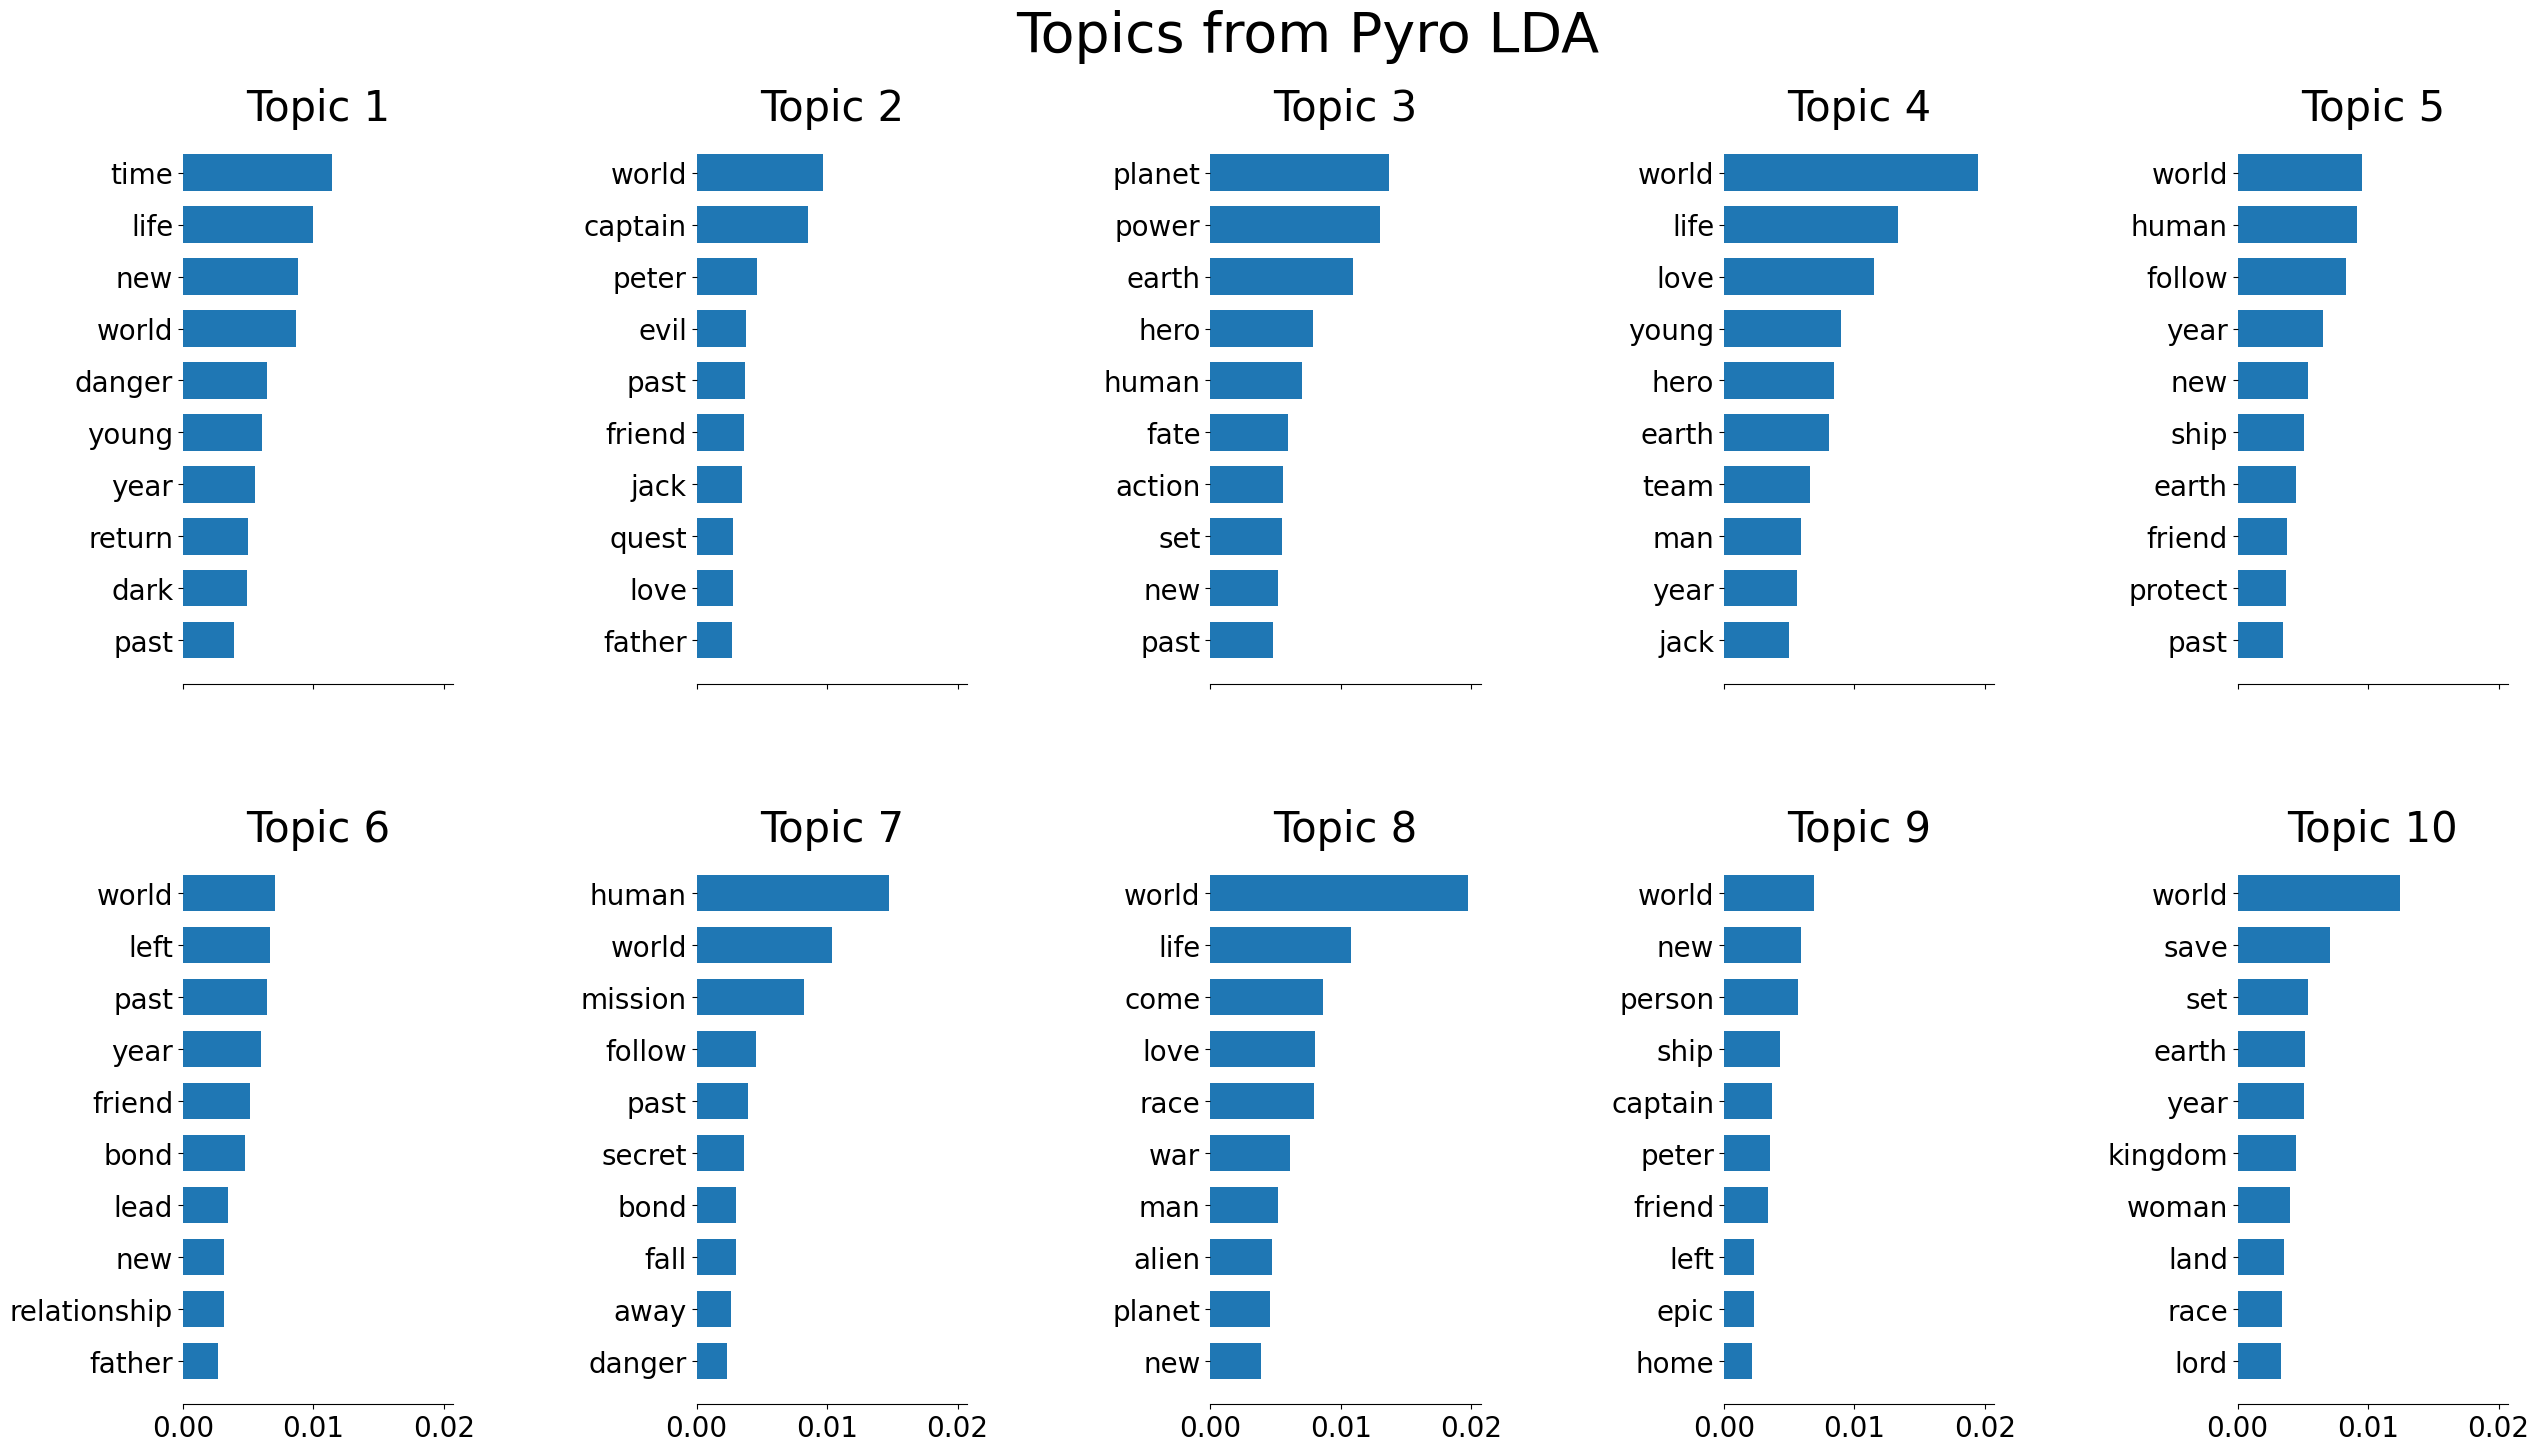

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_words_from_matrix(topic_matrix, dictionary, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(topic_matrix):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = [dictionary[int(idx)] for idx in top_features_ind]
        weights = topic[top_features_ind].cpu().numpy() if hasattr(topic[top_features_ind], "cpu") else topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# Usage:
plot_top_words_from_matrix(topics, pyro_idx_to_word_map, n_top_words=10, title="Topics from Pyro LDA")

In [50]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

from time import time

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time()
data, _ = fetch_20newsgroups(
    shuffle=True,
    random_state=1,
    remove=("headers", "footers", "quotes"),
    return_X_y=True,
)
data_samples = list(df['overview'])
print("done in %0.3fs." % (time() - t0))



Loading dataset...
done in 0.795s.


Extracting tf-idf features for NMF...
done in 0.080s.
Extracting tf features for LDA...
done in 0.073s.

done in 1.453s.


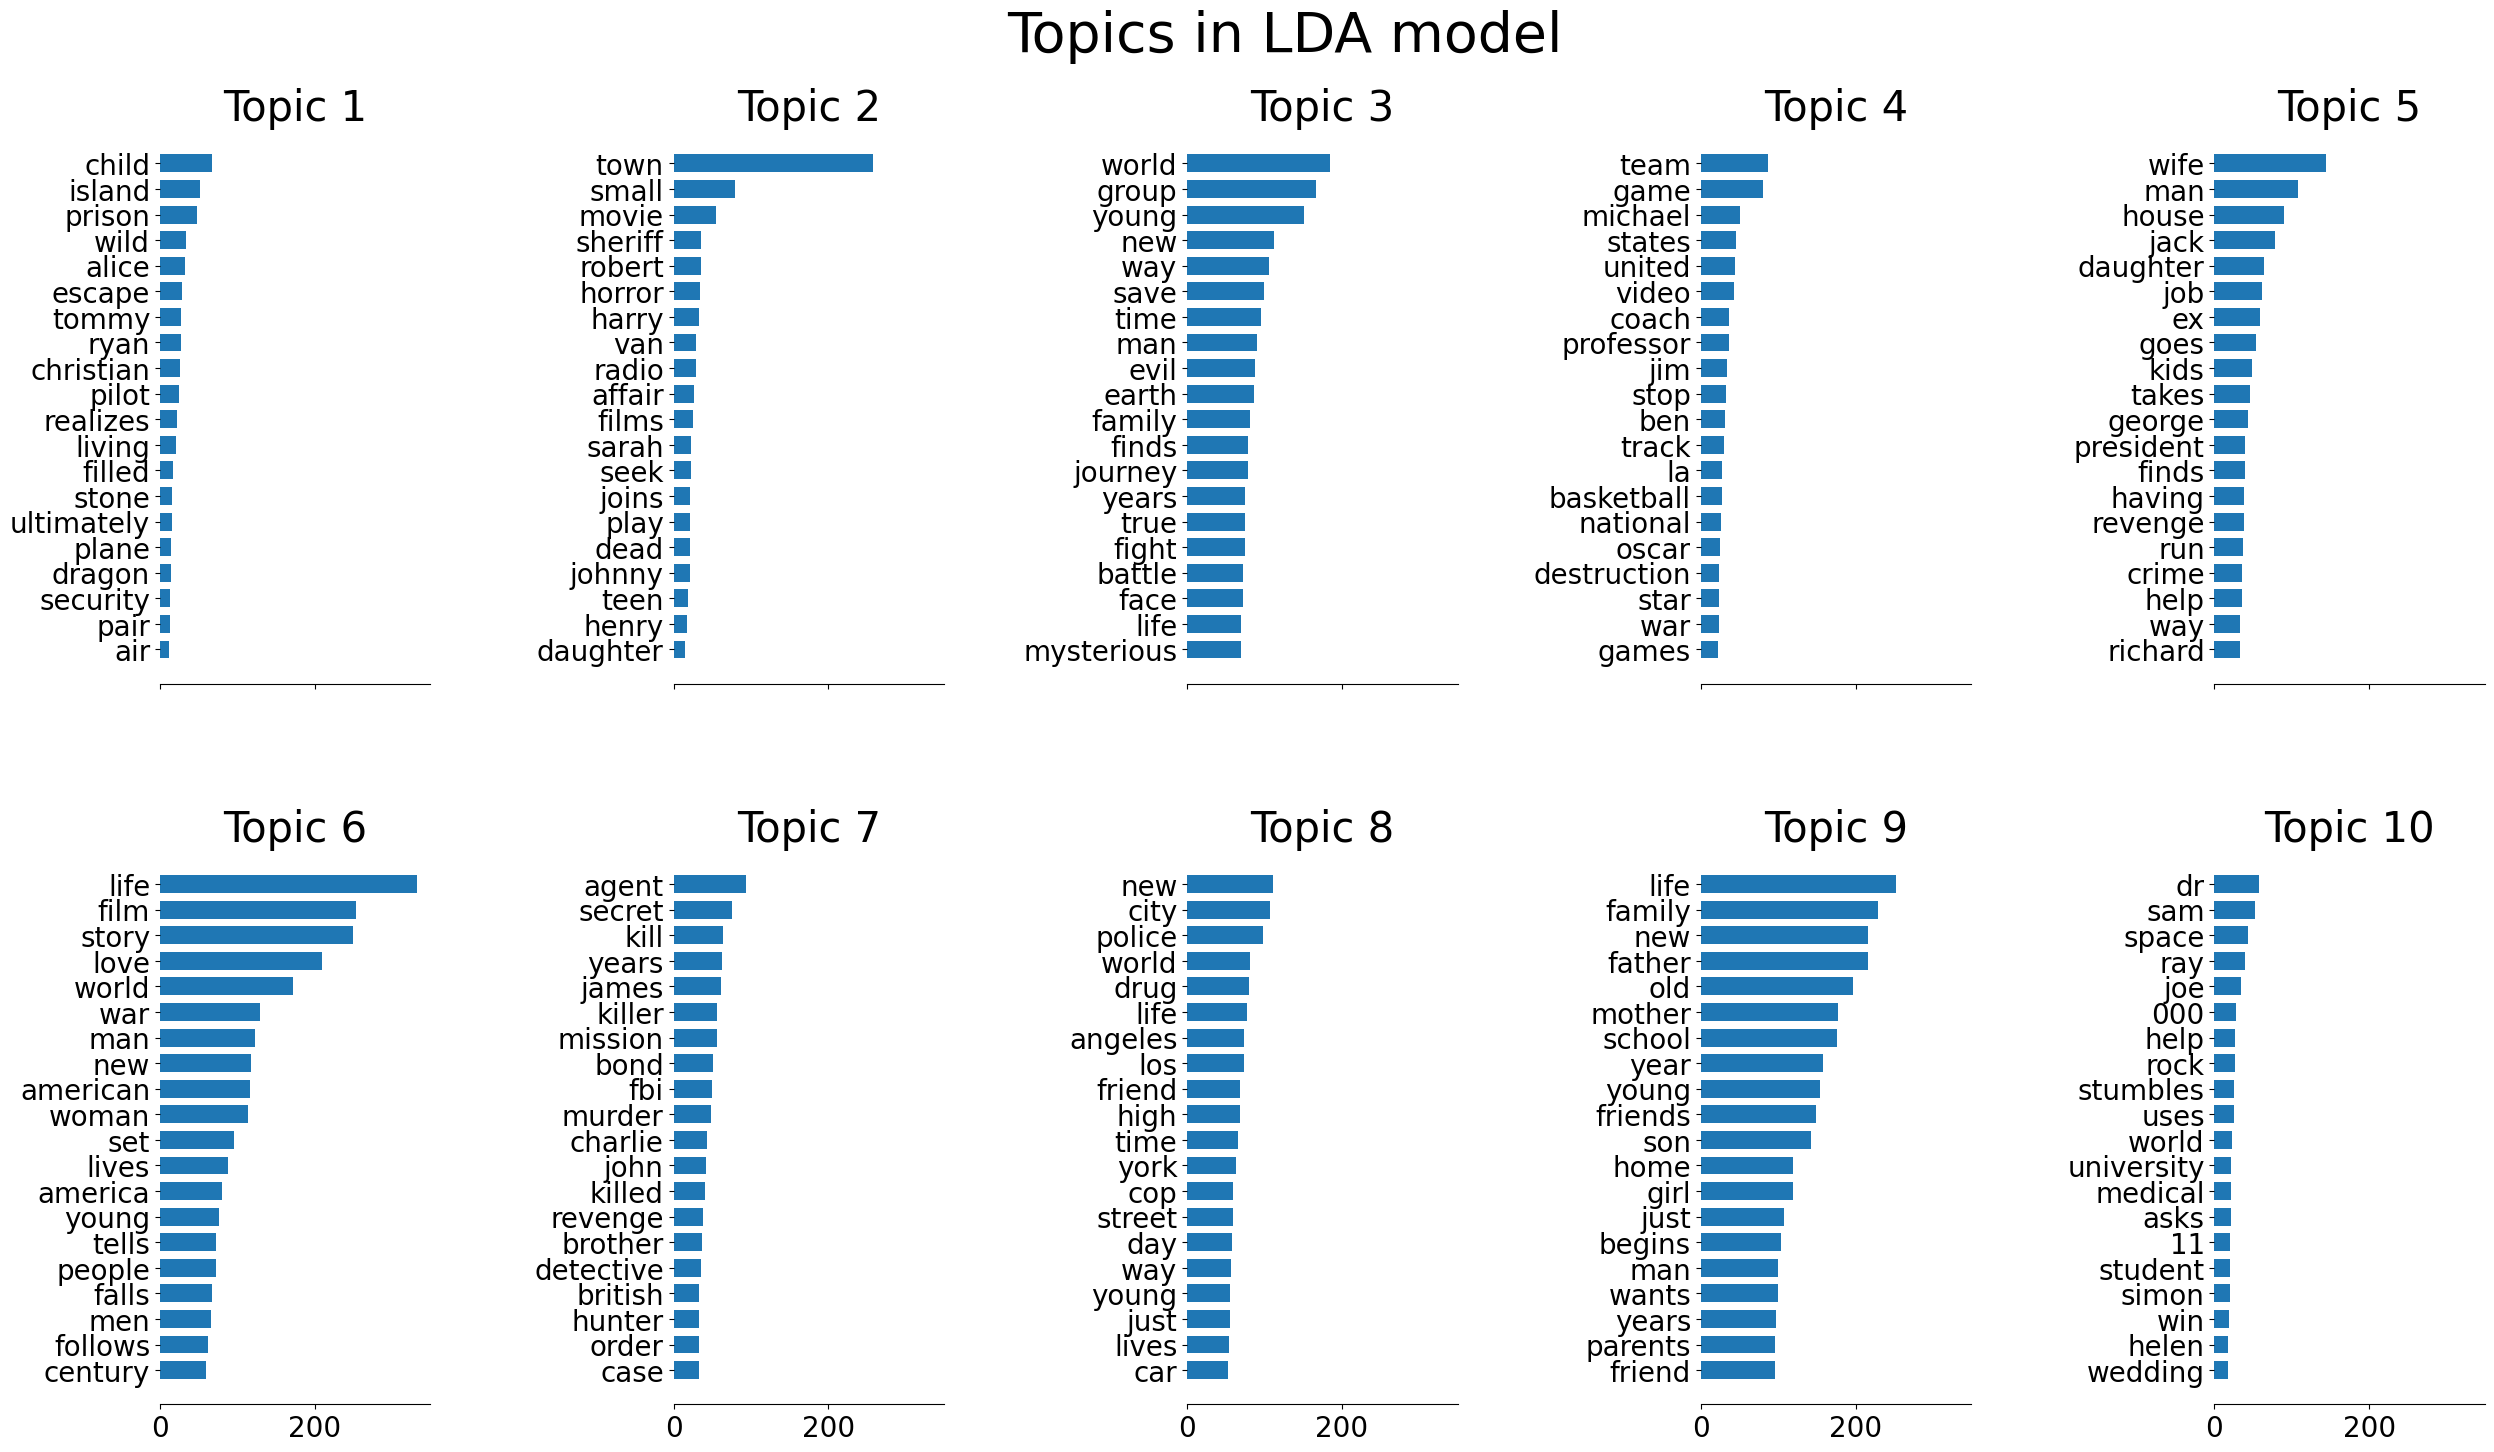

In [97]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()



lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

In [62]:
from sklearn.feature_extraction.text import CountVectorizer
from data import add_mask_column
import torch

import numpy as np
vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=1000, stop_words="english"
)
 
def VectorizeText(text, vectorizer):
    X_count = vectorizer.fit_transform(df['overview'])
    list_of_word_indices_per_doc = []
    if hasattr(X_count, 'indptr'): # Check if it's likely CSR or similar

        for i in range(X_count.shape[0]): # Iterate through each document/row
            word_indices_for_doc_i = X_count[i].indices
            list_of_word_indices_per_doc.append(word_indices_for_doc_i.tolist())

    else:
        for i in range(X_count.shape[0]):
            row = X_count[i].toarray().flatten() # Convert sparse row to dense array
            word_indices_for_doc_i = np.nonzero(row)[0] # Get indices of non-zero elements
            list_of_word_indices_per_doc.append(word_indices_for_doc_i.tolist())
    

    #for i, indices in enumerate(list_of_word_indices_per_doc):
    #    print(f"Document {i}: {indices}")

    # Get the words corresponding to the indices

    return list_of_word_indices_per_doc

# Example usage
list_of_word_indices_per_doc = VectorizeText(df['overview'], vectorizer)
doc = list_of_word_indices_per_doc[1]
# convert to words
df["indexed_overview"] = list_of_word_indices_per_doc
sequence_length = 60

df = add_mask_column(df, 'indexed_overview', 
                         length=sequence_length, 
                         new_column_name="indexed_overview_masked",)

W = df["indexed_overview"]
Mask = df["indexed_overview_masked"]
#rating = df["vote_average"]
#rating = rating.round().astype(int)
#rating = torch.tensor(rating.values, dtype=torch.long)

# Convert to a LongTensor (2D tensor)
tensor_W = torch.tensor(W.tolist(), dtype=torch.long).T
tensor_Mask = torch.tensor(Mask.tolist(), dtype=torch.bool).T


In [58]:
df["indexed_overview"]

0       [125, 932, 582, 895, 322, 30, 0, 0, 0, 0, 0, 0...
1       [112, 525, 206, 157, 515, 250, 258, 0, 0, 0, 0...
2       [87, 645, 778, 902, 926, 796, 632, 668, 328, 7...
3       [322, 210, 689, 494, 147, 667, 995, 495, 262, ...
4       [112, 599, 463, 117, 963, 577, 659, 716, 272, ...
                              ...                        
4798    [909, 529, 135, 917, 298, 898, 984, 469, 478, ...
4799    [179, 798, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4800    [206, 645, 494, 988, 772, 625, 859, 129, 757, ...
4801    [612, 70, 625, 504, 779, 757, 397, 996, 32, 54...
4802    [995, 495, 612, 994, 625, 916, 4, 803, 682, 24...
Name: indexed_overview, Length: 4800, dtype: object

In [50]:
list_of_word_indices_per_doc[1]

[112, 525, 206, 157, 515, 250, 258]